In [1]:
import torch.nn as nn
import torch
import os
import random
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.random import rand, randn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from AffectivNetDataloader import AffectivNetDataset
from torchvision import transforms, utils
from torch.utils.data import DataLoader
from GaborLayers import GaborConv2d
from skimage import io
import time

In [ ]:
gl = GaborConv2d(3, 96, kernel_size=(15,15), stride=2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gl.to(device)
gl.x0

In [ ]:
res = gl(torch.normal(torch.rand(1,3,256,256)).to(device))

In [ ]:
res.backward(torch.ones_like(res))

In [ ]:
gl.theta.grad.shape

In [2]:
transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((256,256)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_set = AffectivNetDataset(root_dir='C:\\Projects\\AffectivNet', csv_file = 'C:\\Projects\\AffectivNet\\clearedTraining.csv', transform=transform, downsample=25000, delete_classes=[4,5,7], check=False)
test_set = AffectivNetDataset(root_dir='C:\\Projects\\AffectivNet', csv_file = 'C:\\Projects\\AffectivNet\\clearedValidation.csv', transform=transform, delete_classes=[4,5,7])

before check: 273719
[0 1 2 3 4]
before check: 2500
after check: 2500
[0 1 2 3 4]


In [3]:
train = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
test = DataLoader(test_set, batch_size=128, shuffle=True, num_workers=4)

In [4]:
len(train)

977

In [5]:
one_layer_gnet_acc_train = []
one_layer_gnet_loss_train = []
one_layer_gnet_acc_test = []
one_layer_gnet_loss_test = []

two_layer_gnet_acc_train = []
two_layer_gnet_loss_train = []
two_layer_gnet_acc_test = []
two_layer_gnet_loss_test = []

convnet_acc_train = []
convnet_loss_train = []
convnet_acc_test = []
convnet_loss_test = []

one_layer_cgnet_acc_train = []
one_layer_cgnet_loss_train = []
one_layer_cgnet_acc_test = []
one_layer_cgnet_loss_test = []

two_layer_cgnet_acc_train = []
two_layer_cgnet_loss_train = []
two_layer_cgnet_acc_test = []
two_layer_cgnet_loss_test = []

In [6]:
class GaborNet_one_layer(nn.Module):
    def __init__(self):
        super(GaborNet_one_layer, self).__init__()
        self.g1 = GaborConv2d(3, 96, kernel_size=(15,15), stride=2)
        self.c1 = nn.Conv2d(96, 256, kernel_size=(3,3), stride=1)
        self.c2 = nn.Conv2d(256, 384, kernel_size=(3,3), stride=1)
        self.c3 = nn.Conv2d(384, 384, kernel_size=(3,3), stride=1)
        self.c4 = nn.Conv2d(384, 256, kernel_size=(3,3), stride=1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.g1(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.c1(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.c2(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.c3(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.c4(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = x.view(-1, 256*1*1)
        x = F.relu(self.fc1(x))
        x = nn.Dropout()(x)
        x = self.fc2(x)
        return x

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight.data)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = GaborNet_one_layer().to(device)
#net.apply(weights_init)
print(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

cuda:0
GaborNet_one_layer(
  (g1): GaborConv2d(3, 96, kernel_size=(15, 15), stride=(2, 2), bias=False)
  (c1): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1))
  (c2): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
  (c3): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1))
  (c4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


In [8]:
net(torch.normal(torch.Tensor(1,3,256,256)).to(device))

tensor([[-0.0537,  0.0152, -0.0630, -0.0497,  0.0359]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [11]:
for epoch in range(10):

    running_loss = 0.0
    correct = 0
    net.train()
    for i, data in enumerate(train, 0):
        # get the inputs
        inputs, labels = data['image'], data['target']

        # zero the parameter gradients
        optimizer.zero_grad()
        labels = labels.type(torch.LongTensor)

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        pred = outputs.max(1, keepdim=True)[1].to('cpu')
        correct += pred.eq(labels.view_as(pred)).sum().item()
        if i != 0 and i % 150 == 0:
            print('#', end = '')

        # print statistics
        running_loss += loss.item()
    print('\n[%d] train_acc: %.3f train_loss: %.3f' %(epoch + 1, correct/len(train_set), running_loss/len(train_set))) 
    one_layer_gnet_acc_train.append(correct/len(train_set))
    one_layer_gnet_loss_train.append(running_loss/len(train_set)) 
    
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        net.eval()
        for i, data in enumerate(test, 0):
            # get the inputs
            inputs, labels = data['image'], data['target']
            labels = labels.type(torch.LongTensor)

            # forward + backward + optimize
            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels.to(device))

            pred = outputs.max(1, keepdim=True)[1].to('cpu')
            correct += pred.eq(labels.view_as(pred)).sum().item()
            running_loss += loss.item()
    print('[%d] test_acc: %.3f test_loss: %.3f' %(epoch + 1, correct/len(test_set), running_loss/len(test_set)))
    one_layer_gnet_acc_test.append(correct/len(test_set))
    one_layer_gnet_loss_test.append(running_loss/len(test_set)) 

print('Finished Training')

np.save('AffectiveNet_new_init_one_layer_gnet_acc_train.npy', one_layer_gnet_acc_train)
np.save('AffectiveNet_new_init_one_layer_gnet_loss_train.npy', one_layer_gnet_loss_train)
np.save('AffectiveNet_new_init_one_layer_gnet_acc_test.npy', one_layer_gnet_acc_test)
np.save('AffectiveNet_new_init_one_layer_gnet_loss_test.npy', one_layer_gnet_loss_test)

######
[1] train_acc: 0.687 train_loss: 0.006
[1] test_acc: 0.636 test_loss: 0.008
######
[2] train_acc: 0.688 train_loss: 0.006
[2] test_acc: 0.635 test_loss: 0.008
######
[3] train_acc: 0.689 train_loss: 0.006
[3] test_acc: 0.614 test_loss: 0.008
######
[4] train_acc: 0.690 train_loss: 0.006
[4] test_acc: 0.635 test_loss: 0.008
######
[5] train_acc: 0.691 train_loss: 0.006
[5] test_acc: 0.620 test_loss: 0.008
######
[6] train_acc: 0.693 train_loss: 0.006
[6] test_acc: 0.636 test_loss: 0.008
######
[7] train_acc: 0.692 train_loss: 0.006
[7] test_acc: 0.622 test_loss: 0.008
######
[8] train_acc: 0.694 train_loss: 0.006
[8] test_acc: 0.624 test_loss: 0.008
######
[9] train_acc: 0.694 train_loss: 0.006
[9] test_acc: 0.632 test_loss: 0.008
######
[10] train_acc: 0.695 train_loss: 0.006
[10] test_acc: 0.638 test_loss: 0.008
Finished Training


In [10]:
optimizer = optim.Adam(net.parameters(), lr=0.00001)

In [ ]:
np.save('AffectiveNet_new_init_one_layer_gnet_acc_train.npy', one_layer_gnet_acc_train)
np.save('AffectiveNet_new_init_one_layer_gnet_loss_train.npy', one_layer_gnet_loss_train)
np.save('AffectiveNet_new_init_one_layer_gnet_acc_test.npy', one_layer_gnet_acc_test)
np.save('AffectiveNet_new_init_one_layer_gnet_loss_test.npy', one_layer_gnet_loss_test)

In [ ]:
class convNet(nn.Module):
    def __init__(self):
        super(convNet, self).__init__()
        self.c0 = nn.Conv2d(3, 96, kernel_size=(11,11), stride=2)
        self.c1 = nn.Conv2d(96, 256, kernel_size=(3,3), stride=1)
        self.c2 = nn.Conv2d(256, 384, kernel_size=(3,3), stride=1)
        self.c3 = nn.Conv2d(384, 384, kernel_size=(3,3), stride=1)
        self.c4 = nn.Conv2d(384, 256, kernel_size=(3,3), stride=1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.c0(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.c1(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.c2(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.c3(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.c4(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = x.view(-1, 256*1*1)
        x = F.relu(self.fc1(x))
        x = nn.Dropout()(x)
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = convNet().to(device)
net.apply(weights_init)
print(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
net(torch.normal(torch.Tensor(1,3,256,256)).to(device))

In [ ]:
for epoch in range(10):

    running_loss = 0.0
    correct = 0
    net.train()
    for i, data in enumerate(train, 0):
        # get the inputs
        inputs, labels = data['image'], data['target']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        labels = labels.type(torch.LongTensor)
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        pred = outputs.max(1, keepdim=True)[1].to('cpu')
        correct += pred.eq(labels.view_as(pred)).sum().item()
        if i != 0 and i % 150 == 0:
            print('#', end = '')

        # print statistics
        running_loss += loss.item()
    print('\n[%d] train_acc: %.3f train_loss: %.3f' %(epoch + 1, correct/len(train_set), running_loss/len(train_set)), end= '\n') 
    convnet_acc_train.append(correct/len(train_set))
    convnet_loss_train.append(running_loss/len(train_set)) 
    
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        net.eval()
        for i, data in enumerate(test, 0):
            # get the inputs
            inputs, labels = data['image'], data['target']
            labels = labels.type(torch.LongTensor)

            # forward + backward + optimize
            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels.to(device))

            pred = outputs.max(1, keepdim=True)[1].to('cpu')
            correct += pred.eq(labels.view_as(pred)).sum().item()
            running_loss += loss.item()
    print('[%d] test_acc: %.3f test_loss: %.3f' %(epoch + 1, correct/len(test_set), running_loss/len(test_set)))
    convnet_acc_test.append(correct/len(test_set))
    convnet_loss_test.append(running_loss/len(test_set))      

print('Finished Training')

np.save('AffectiveNet_convnet_acc_train.npy', convnet_acc_train)
np.save('AffectiveNet_convnet_loss_train.npy', convnet_loss_train)
np.save('AffectiveNet_convnet_acc_test.npy', convnet_acc_test)
np.save('AffectiveNet_convnet_loss_test.npy', convnet_loss_test)

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.00001)

In [ ]:
np.save('AffectiveNet_convnet_acc_train.npy', convnet_acc_train)
np.save('AffectiveNet_convnet_loss_train.npy', convnet_loss_train)
np.save('AffectiveNet_convnet_acc_test.npy', convnet_acc_test)
np.save('AffectiveNet_convnet_loss_test.npy', convnet_loss_test)

In [14]:
one_layer_gnet_acc_train = np.load('AffectiveNet_new_init_one_layer_gnet_acc_train.npy')
convnet_acc_train = np.load('AffectiveNet_convnet_acc_train.npy')

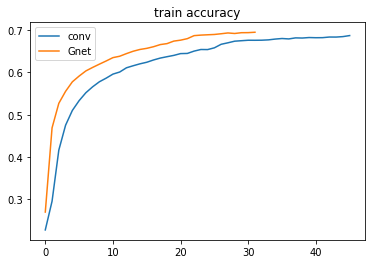

In [15]:
plt.plot(convnet_acc_train, label = 'conv')
plt.plot(one_layer_gnet_acc_train, label = 'Gnet')
plt.legend(loc = 0)
plt.title('train accuracy')
plt.show()

In [16]:
#one_layer_gnet_acc_test = np.load('AffectiveNet_one_layer_gnet_acc_test.npy')
convnet_acc_test = np.load('AffectiveNet_convnet_acc_test.npy')

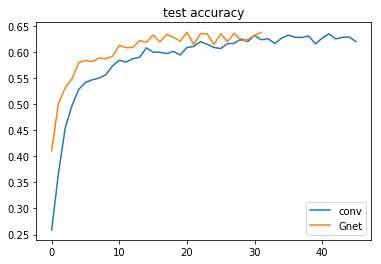

In [17]:
plt.plot(convnet_acc_test, label = 'conv')
plt.plot(one_layer_gnet_acc_test, label = 'Gnet')
plt.legend(loc = 0)
plt.title('test accuracy')
plt.show()